# KoBART Basline Train - 4K
- GKSL 4K
- 모듈에서 불러오는 모델 아니고 huggingface에서 불러와서 적용
- 일반적 tokenizer말고 BART에 최적화된 토크나이저 불러옴

https://huggingface.co/hyunwoongko/kobart

## 0. 라이브러리 및 데이터 불러오기

In [31]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim

#from google.colab import drive
#drive.mount('/content/drive')

In [32]:
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained('hyunwoongko/kobart')
model = BartForConditionalGeneration.from_pretrained("hyunwoongko/kobart")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


In [33]:
model.config

BartConfig {
  "_name_or_path": "hyunwoongko/kobart",
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "author": "Heewon Jeon(madjakarta@gmail.com)",
  "bos_token_id": 1,
  "classif_dropout": 0.1,
  "classifier_dropout": 0.1,
  "d_model": 768,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 3072,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 1,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 3072,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 1,
  "extra_pos_embeddings": 2,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "kobart_ve

In [34]:
model.generate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([[    1, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309,
         15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309, 15309,     1]])

In [35]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): Laye

데이터 불러오기

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/AIRC-KETI/GKSL-dataset/main/dataset/GKSL13k_augmented.csv')
df.columns = ['augmentation_method', 'idx', 'gloss', 'text']
df.head(30)

,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
8,SR,9,1호 갈아타다 목적 곳곳,1호선 환승하는 위치는 어디인가요?
9,SR,10,1호 갈아타다 목적 곳곳,1호선 환승하는 장소는 어디인가요?


## 1. 데이터 파악

In [37]:
len(df), len(df.gloss.unique()), len(df.text.unique())

(13047, 11345, 8451)

In [38]:
for i in df.augmentation_method.unique():
  print(i, ':', len(df[df.augmentation_method==i]))

SR : 899
SP : 1494
BR : 10654


In [39]:
# '?'가 포함된 행 제거
print(len(df[~df['text'].str.contains('\?')])/len(df)) # 절반 이상 날라감
df[~df['text'].str.contains('\?')].head(10)

0.6439028129071818


,augmentation_method,idx,gloss,text
0,SR,1,집 불,댁에 불이 났어요.
1,SR,2,집 불,주택에 불이 났어요.
2,SR,3,집 불,가옥에 불이 났어요.
3,SR,4,집 불,세대에 불이 났어요.
4,SR,5,도착 10분 전,10분 내로 당도합니다.
5,SR,6,도착 10분,10분 뒤에 당도합니다.
6,SR,7,도착 1시간 전,1시간 내로 당도합니다.
7,SR,8,도착 1시,1시에 당도합니다.
12,SR,13,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,SR,14,도착 3시,3시에 당도합니다.


### 데이터 전처리

In [40]:
df = df[~df['text'].str.contains('\?')]
df = df[['gloss', 'text']]
df.head(30)

,gloss,text
0,집 불,댁에 불이 났어요.
1,집 불,주택에 불이 났어요.
2,집 불,가옥에 불이 났어요.
3,집 불,세대에 불이 났어요.
4,도착 10분 전,10분 내로 당도합니다.
5,도착 10분,10분 뒤에 당도합니다.
6,도착 1시간 전,1시간 내로 당도합니다.
7,도착 1시,1시에 당도합니다.
12,2016 새롭다 날 시작,"2016년, 새해가 출발한다"
13,도착 3시,3시에 당도합니다.


### 문장 길이 시각화
max_len 설정을 위함

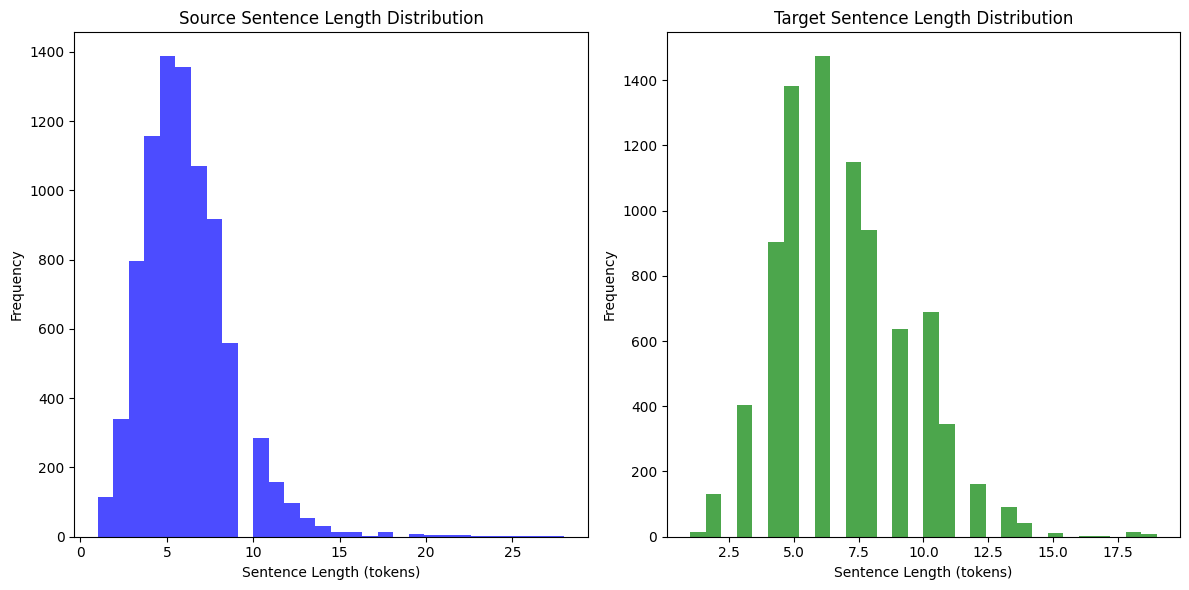

In [41]:
import matplotlib.pyplot as plt

# 각 문장의 토큰 길이를 KoBART 토크나이저로 계산 -> 서브워드 단어로 더 잘게 쪼개줌
df['source_len'] = df['gloss'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))
df['target_len'] = df['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=False)))

# 히스토그램을 그려서 분포 확인
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(df['source_len'], bins=30, color='blue', alpha=0.7)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(df['target_len'], bins=30, color='green', alpha=0.7)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Sentence Length (tokens)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [42]:
# 문장 길이 통계
source_stats = df['source_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])
target_stats = df['target_len'].describe(percentiles=[.25, .5, .75, .9, .95, .99])

print("Source Sentence Length Stats:\n", source_stats)
print("\nTarget Sentence Length Stats:\n", target_stats)

Source Sentence Length Stats:
 count    8401.000000
mean        6.081776
std         2.704424
min         1.000000
25%         4.000000
50%         6.000000
75%         8.000000
90%         9.000000
95%        10.000000
99%        14.000000
max        28.000000
Name: source_len, dtype: float64

Target Sentence Length Stats:
 count    8401.000000
mean        6.805618
std         2.523546
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
90%        10.000000
95%        11.000000
99%        13.000000
max        19.000000
Name: target_len, dtype: float64


## 2. 데이터 로더 생성

In [43]:
class GlossDataset(Dataset):
    def __init__(self, glosses, texts, tokenizer, max_len=10):
        self.glosses = glosses
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    # 데이터셋의 크기를 반환
    def __len__(self):
        return len(self.glosses)

    def __getitem__(self, idx):
        # 데이터 로드 및 전처리
        gloss = str(self.glosses[idx])
        text = str(self.texts[idx])

        # 토큰화
        inputs = self.tokenizer(
            gloss,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt" # 토큰화된 결과를 PyTorch 텐서로 반환
        )

        outputs = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # 텐서 데이터 처리
        input_ids = inputs.input_ids.squeeze() # 1차원 처리해 gloss 토큰 id 텐서
        attention_mask = inputs.attention_mask.squeeze() # 마스킹 처리
        labels = outputs.input_ids.squeeze() # 1차원 처리해 text 토큰 id 텐서
        labels[labels == tokenizer.pad_token_id] = -100  # labels 텐서에서 패딩 토큰의 ID를 -100 변경 -> 학습 시 영향 안줌

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        } # 모델 학습에 사용될 데이터 로더에 의해 처리

In [44]:
from sklearn.model_selection import train_test_split

# 데이터셋 분할
train_glosses, val_glosses, train_texts, val_texts = train_test_split(df['gloss'].tolist(), df['text'].tolist(), test_size=0.2, random_state=42)
val_glosses, test_glosses, val_texts, test_texts = train_test_split(val_glosses, val_texts, test_size=0.5, random_state=42)

# 데이터셋 생성
train_dataset = GlossDataset(glosses=train_glosses, texts=train_texts, tokenizer=tokenizer)
val_dataset = GlossDataset(glosses=val_glosses, texts=val_texts, tokenizer=tokenizer)
test_dataset = GlossDataset(glosses=test_glosses, texts=test_texts, tokenizer=tokenizer)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [45]:
train_dataset[0]

{'input_ids': tensor([    0, 20438, 23304, 23929, 17992,     1,     3,     3,     3,     3]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0]),
 'labels': tensor([    0, 18388, 23304, 10325, 15170,     1,  -100,  -100,  -100,  -100])}

## 3. 모델 준비

In [28]:
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# 옵티마이저와 손실 함수 설정
optimizer = AdamW(model.parameters(), lr=3e-5)  # 학습률은 실험적으로 조정할 수 있음 1e-4, 1e-5
loss_fn = torch.nn.CrossEntropyLoss()

# 학습률 스케줄러 설정
num_epochs = 50

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## 4. KoBART 학습


In [29]:
# 체크포인트를 저장할 디렉토리 설정
import os

checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [30]:
import tqdm
from tqdm import tqdm

# 손실 값을 저장할 리스트 초기화
train_losses = []
val_losses = []

# 조기 종료 변수 설정
# early_stopping_patience = 5  # 손실 개선이 없을 때 기다리는 에포크 수
best_val_loss = float('inf')
epochs_since_improvement = 0

for epoch in range(num_epochs):
    model.train()  # 학습 모드로 전환
    total_loss = 0

    print(f'\nStarting epoch {epoch+1}/{num_epochs}')

    # tqdm을 사용하여 배치 진행 상태 표시
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        optimizer.zero_grad()  # 기울기 초기화

        # 모델에 데이터 전달
        outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
        loss = outputs.loss

        loss.backward()  # 역전파
        optimizer.step()  # 옵티마이저 스텝
        scheduler.step()  # 학습률 스케줄러 스텝

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_loss)  # 훈련 손실 저장

    # Epoch 종료 후 검증 데이터셋에서 성능 평가
    model.eval()  # 평가 모드로 전환
    total_val_loss = 0
    with torch.no_grad():
        # tqdm을 사용하여 검증 배치 진행 상태 표시
        for batch in tqdm(val_dataloader, desc='Validation', unit='batch'):
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], labels=batch['labels'])
            loss = outputs.loss
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)  # 검증 손실 저장

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}, Validation Loss: {avg_val_loss}')

    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': avg_loss,
        'val_loss': avg_val_loss,
    }, checkpoint_path)

    print(f'Checkpoint saved to {checkpoint_path}')

    # 조기 종료 확인
   # if avg_val_loss < best_val_loss:
   #     best_val_loss = avg_val_loss
   #     epochs_since_improvement = 0  # 손실 개선이 있으면 카운트 리셋
   # else:
   #     epochs_since_improvement += 1
   #     if epochs_since_improvement >= early_stopping_patience:
   #         print(f"Early stopping triggered. No improvement for {early_stopping_patience} epochs.")
   #         break


Starting epoch 1/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.01batch/s]


Epoch 1/30, Loss: 2.0497562225375856, Validation Loss: 1.1544767055871352
Checkpoint saved to ./checkpoints/checkpoint_epoch_1.pt

Starting epoch 2/30


Validation: 100%|██████████| 53/53 [00:09<00:00,  5.36batch/s]


Epoch 2/30, Loss: 0.8811083383503414, Validation Loss: 0.7800636550165573
Checkpoint saved to ./checkpoints/checkpoint_epoch_2.pt

Starting epoch 3/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.11batch/s]


Epoch 3/30, Loss: 0.5239013344049454, Validation Loss: 0.6697397732509757
Checkpoint saved to ./checkpoints/checkpoint_epoch_3.pt

Starting epoch 4/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.01batch/s]


Epoch 4/30, Loss: 0.3583421323271025, Validation Loss: 0.6249694135391487
Checkpoint saved to ./checkpoints/checkpoint_epoch_4.pt

Starting epoch 5/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.95batch/s]


Epoch 5/30, Loss: 0.2631731305271387, Validation Loss: 0.6216067230364062
Checkpoint saved to ./checkpoints/checkpoint_epoch_5.pt

Starting epoch 6/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.10batch/s]


Epoch 6/30, Loss: 0.19912065235631807, Validation Loss: 0.6064272371103179
Checkpoint saved to ./checkpoints/checkpoint_epoch_6.pt

Starting epoch 7/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.93batch/s]


Epoch 7/30, Loss: 0.15799840678505245, Validation Loss: 0.6080417686475897
Checkpoint saved to ./checkpoints/checkpoint_epoch_7.pt

Starting epoch 8/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.03batch/s]


Epoch 8/30, Loss: 0.13281801163795448, Validation Loss: 0.6146039341418248
Checkpoint saved to ./checkpoints/checkpoint_epoch_8.pt

Starting epoch 9/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.04batch/s]


Epoch 9/30, Loss: 0.12563336192231092, Validation Loss: 0.614838218632734
Checkpoint saved to ./checkpoints/checkpoint_epoch_9.pt

Starting epoch 10/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.08batch/s]


Epoch 10/30, Loss: 0.10322120875741045, Validation Loss: 0.6196151783443847
Checkpoint saved to ./checkpoints/checkpoint_epoch_10.pt

Starting epoch 11/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.12batch/s]


Epoch 11/30, Loss: 0.09811233602065061, Validation Loss: 0.6351565918270147
Checkpoint saved to ./checkpoints/checkpoint_epoch_11.pt

Starting epoch 12/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.01batch/s]


Epoch 12/30, Loss: 0.08708995711945353, Validation Loss: 0.6358681641659647
Checkpoint saved to ./checkpoints/checkpoint_epoch_12.pt

Starting epoch 13/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.17batch/s]


Epoch 13/30, Loss: 0.08157616909482472, Validation Loss: 0.63221542087366
Checkpoint saved to ./checkpoints/checkpoint_epoch_13.pt

Starting epoch 14/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.97batch/s]


Epoch 14/30, Loss: 0.07790151245537258, Validation Loss: 0.6379031134101579
Checkpoint saved to ./checkpoints/checkpoint_epoch_14.pt

Starting epoch 15/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.09batch/s]


Epoch 15/30, Loss: 0.07199335055580984, Validation Loss: 0.6497814284180695
Checkpoint saved to ./checkpoints/checkpoint_epoch_15.pt

Starting epoch 16/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.14batch/s]


Epoch 16/30, Loss: 0.08206839777107927, Validation Loss: 0.651125801059435
Checkpoint saved to ./checkpoints/checkpoint_epoch_16.pt

Starting epoch 17/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.00batch/s]


Epoch 17/30, Loss: 0.06311392419572387, Validation Loss: 0.6477099434947068
Checkpoint saved to ./checkpoints/checkpoint_epoch_17.pt

Starting epoch 18/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.93batch/s]


Epoch 18/30, Loss: 0.0593360904182884, Validation Loss: 0.6524485701097632
Checkpoint saved to ./checkpoints/checkpoint_epoch_18.pt

Starting epoch 19/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.99batch/s]


Epoch 19/30, Loss: 0.05733920245963548, Validation Loss: 0.6524757675404819
Checkpoint saved to ./checkpoints/checkpoint_epoch_19.pt

Starting epoch 20/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.09batch/s]


Epoch 20/30, Loss: 0.05358353332461168, Validation Loss: 0.6684089691009162
Checkpoint saved to ./checkpoints/checkpoint_epoch_20.pt

Starting epoch 21/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.96batch/s]


Epoch 21/30, Loss: 0.05251232598730851, Validation Loss: 0.6623903940308769
Checkpoint saved to ./checkpoints/checkpoint_epoch_21.pt

Starting epoch 22/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.08batch/s]


Epoch 22/30, Loss: 0.050012929505845974, Validation Loss: 0.659849187956666
Checkpoint saved to ./checkpoints/checkpoint_epoch_22.pt

Starting epoch 23/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.89batch/s]


Epoch 23/30, Loss: 0.048585584441510336, Validation Loss: 0.6649165547118997
Checkpoint saved to ./checkpoints/checkpoint_epoch_23.pt

Starting epoch 24/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.94batch/s]


Epoch 24/30, Loss: 0.04598025127114462, Validation Loss: 0.6669404360483278
Checkpoint saved to ./checkpoints/checkpoint_epoch_24.pt

Starting epoch 25/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.14batch/s]


Epoch 25/30, Loss: 0.044286733401739706, Validation Loss: 0.6738402174328858
Checkpoint saved to ./checkpoints/checkpoint_epoch_25.pt

Starting epoch 26/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.03batch/s]


Epoch 26/30, Loss: 0.04194522646167094, Validation Loss: 0.6772914607569857
Checkpoint saved to ./checkpoints/checkpoint_epoch_26.pt

Starting epoch 27/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.89batch/s]


Epoch 27/30, Loss: 0.040757536976265586, Validation Loss: 0.6795012239577636
Checkpoint saved to ./checkpoints/checkpoint_epoch_27.pt

Starting epoch 28/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  5.02batch/s]


Epoch 28/30, Loss: 0.039041267340958474, Validation Loss: 0.6801753100359215
Checkpoint saved to ./checkpoints/checkpoint_epoch_28.pt

Starting epoch 29/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.83batch/s]


Epoch 29/30, Loss: 0.037333104569586884, Validation Loss: 0.6814545929994223
Checkpoint saved to ./checkpoints/checkpoint_epoch_29.pt

Starting epoch 30/30


Validation: 100%|██████████| 53/53 [00:10<00:00,  4.99batch/s]


Epoch 30/30, Loss: 0.035481428595015865, Validation Loss: 0.6819489598274231
Checkpoint saved to ./checkpoints/checkpoint_epoch_30.pt


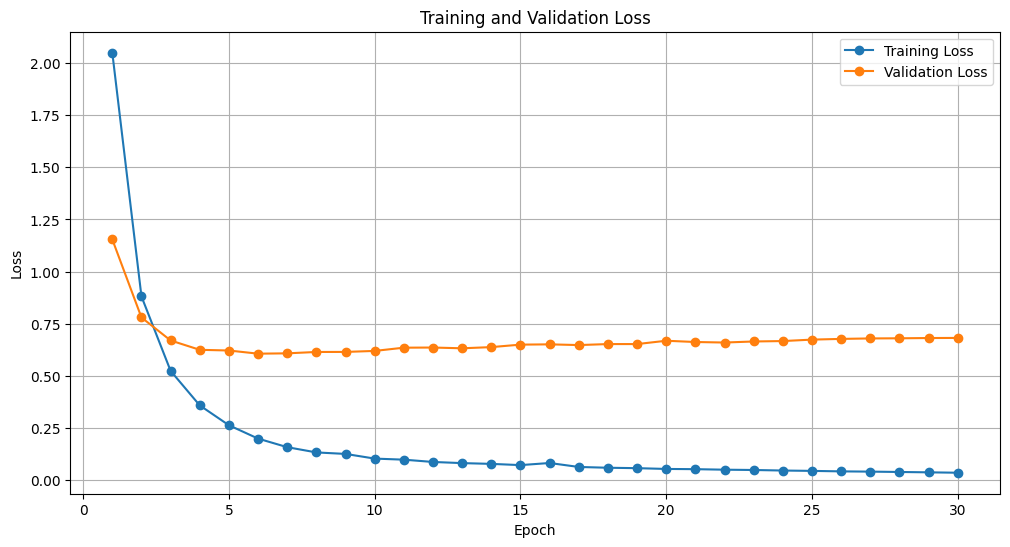

In [46]:
# 손실 값 시각화
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

## 5. test

In [47]:
# 체크포인트 로드
checkpoint_path = './checkpoints/checkpoint_epoch_7.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

In [48]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.0 MB/s eta 0:00:00


In [49]:
import sacrebleu

# 모델을 평가 모드로 설정
model.eval()

# 예측 및 참조 번역 수집
predictions = []
references = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # 모델에 데이터 전달
        outputs = model.generate(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask'],
            max_length=256,  # 적절한 max_length 설정
            length_penalty=2.0,  # 번역 길이 조절
            num_beams=4,  # 빔 서치의 수
            early_stopping=True
        )

        # 예측 결과 디코딩
        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # 실제 레이블 디코딩
        decoded_labels = []
        for label in batch['labels']:
            # 패딩 토큰 ID 제외
            label_ids = label[label != tokenizer.pad_token_id].tolist()
            if label_ids:
                try:
                    decoded_label = tokenizer.decode(label_ids, skip_special_tokens=True)
                except OverflowError:
                    decoded_label = "[UNK]"  # Unknown token으로 처리
                decoded_labels.append(decoded_label)
            else:
                decoded_labels.append('')  # 빈 문자열로 처리

        # 예측 결과와 참조 번역 수집
        predictions.extend(decoded_preds)
        references.extend(decoded_labels)

# BLEU 점수 계산
bleu_score = sacrebleu.corpus_bleu(predictions, [references])
print(f'BLEU score: {bleu_score.score:.4f}')


Evaluating: 100%|██████████| 53/53 [00:53<00:00,  1.01s/it]

BLEU score: 30.8891


In [ ]:
# 기본
import torch

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    for sentence in sentences:
        # 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        for output in output_ids:
            translation = tokenizer.decode(output, skip_special_tokens=True)
            translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
# test_sentences = ["날씨 덥다 화 난다.", "지금 바쁘다 미래 연락."]
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '목 자주 마시고 싶어']


In [ ]:
# 앞 문장과 합성해서 뒷 문장 내용 추출

def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []

    for i, sentence in enumerate(sentences):
        if i > 0:
            # 이전 번역된 문장을 참조하지 않고 현재 문장만 입력으로 사용
            combined_sentence = sentences[i-1] + " " + sentence
        else:
            combined_sentence = sentence

        # 토큰화 및 텐서 변환
        inputs = tokenizer(combined_sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동
        input_ids = inputs['input_ids'].to(model.device)
        attention_mask = inputs['attention_mask'].to(model.device)

        # 모델에 데이터 전달
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

['날씨가 더워서 화났다', '날씨가 더워서 목이 마르고 싶다']


In [ ]:
# context vector 고려해 문장 생성.. -> 해결 미 완료
def generate_translation(model, tokenizer, sentences, max_length=50):
    model.eval()
    translations = []
    context_vector = None

    for sentence in sentences:
        # 현재 문장만을 토큰화 및 텐서 변환
        inputs = tokenizer(sentence, return_tensors='pt', truncation=True, padding='max_length', max_length=max_length)

        # GPU가 사용 중이면 데이터를 GPU로 이동하고 Long 타입으로 변환
        input_ids = inputs['input_ids'].to(model.device).long()
        attention_mask = inputs['attention_mask'].to(model.device).long()

        # 문맥 벡터가 있는 경우 이를 입력에 반영
        if context_vector is not None:
            # 문맥 벡터를 추가할 때, 크기를 맞추기 위해 적절히 변환
            context_vector = context_vector.unsqueeze(1)  # [batch_size, 1, hidden_size]

            # 문맥 벡터를 다음 문장의 시작으로 사용 (단일 벡터로 시작 부분을 교체)
            input_ids = torch.cat([context_vector.squeeze(2).long(), input_ids[:, 1:]], dim=1)
            attention_mask = torch.cat([torch.ones_like(context_vector.squeeze(2)), attention_mask[:, 1:]], dim=1)

        # 모델에 데이터 전달
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        context_vector = outputs.encoder_last_hidden_state[:, -1, :]  # 인코더의 마지막 히든 상태를 문맥 벡터로 사용

        # 텍스트 생성
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=5,  # Beam search 설정
            early_stopping=True
        )

        # 디코딩
        translation = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        translations.append(translation)

    return translations

In [ ]:
# 테스트 문장
test_sentences = ["날씨 덥다 화 난다", "목 마르다 물 원하다"]

# 번역 결과 생성
translations = generate_translation(model, tokenizer, test_sentences)
print(translations)

RuntimeError: Tensors must have same number of dimensions: got 3 and 2